# 第9部　一般化線形モデル

## 4章　ポアソン回帰

### 実装：分析の準備

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats
# 表示桁数の設定
pd.set_option('display.precision', 3)
np.set_printoptions(precision=3)

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
# グラフの日本語表記
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Meiryo'

# 統計モデルを推定するライブラリ
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
# 表示設定(書籍本文のレイアウトと合わせるためであり、必須ではありません)
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 60)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

### 実装：ポアソン分布

#### ポアソン分布の確率質量関数

In [3]:
# ポアソン分布の確率質量関数
round(stats.poisson.pmf(k=1, mu=2), 3)

0.271

In [4]:
# λ=2のポアソン分布に従う乱数
np.random.seed(1)
stats.poisson.rvs(mu=2, size=5)

array([2, 1, 0, 1, 2])

<AxesSubplot:>

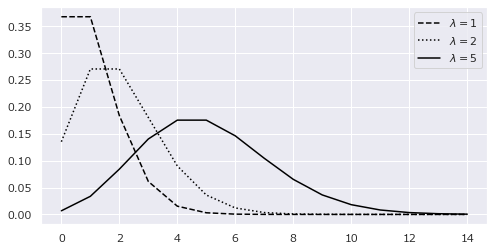

In [5]:
#  λを変化させたポアソン分布の確率質量関数
x = np.arange(0,15,1)
poisson_lambda1 = stats.poisson.pmf(mu=1, k=x)
poisson_lambda2 = stats.poisson.pmf(mu=2, k=x)
poisson_lambda5 = stats.poisson.pmf(mu=5, k=x)

# ポアソン分布の確率質量関数の折れ線グラフ
sns.lineplot(x=x, y=poisson_lambda1, color='black', 
             linestyle='dashed', label='$\lambda=1$')
sns.lineplot(x=x, y=poisson_lambda2, color='black', 
             linestyle='dotted', label='$\lambda=2$')
sns.lineplot(x=x, y=poisson_lambda5, color='black', 
             linestyle='solid', label='$\lambda=5$')

#### ポアソン分布と二項分布の関係

<AxesSubplot:>

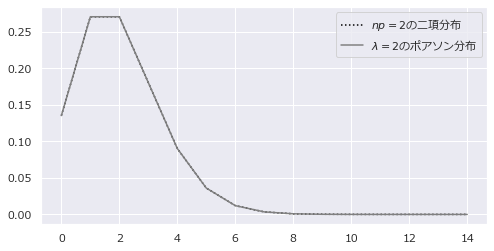

In [6]:
# pが小さくnが大きい二項分布
p = 0.00000002
n = 100000000
binomial = stats.binom.pmf(n=n, p=p, k=x)

# 二項分布とポアソン分布の比較
sns.lineplot(x=x, y=binomial, color='black', 
             linestyle = 'dotted', 
             label='$np=2$の二項分布')
sns.lineplot(x=x, y=poisson_lambda2, color='gray',
             linestyle='solid', 
             label='$\lambda=2$のポアソン分布')

### 実装：データの読み込み

In [7]:
# データの読み込み
beer = pd.read_csv('9-4-1-poisson-regression.csv')
print(beer.head(3))

   beer_number  temperature
0            6         17.5
1           11         26.6
2            2          5.0


### 実装：ポアソン回帰

In [8]:
# モデル化
mod_pois = smf.glm('beer_number ~ temperature', beer, 
                   family=sm.families.Poisson()).fit()
mod_pois.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            beer_number   No. Observations:                   30
Model:                            GLM   Df Residuals:                       28
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -57.672
Date:                Sun, 22 May 2022   Deviance:                       5.1373
Time:                        15:52:55   Pearson chi2:                     5.40
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.4476      0.199      2.253      0.024       0.058       0.837
temperature     0.0761      0.008      9.784      0.000       0.061       0.091
===============================================================================
"""

### 実装：ポアソン回帰のモデル選択

In [9]:
# Nullモデル
mod_pois_null = smf.glm(
    'beer_number ~ 1', data=beer, 
    family=sm.families.Poisson()).fit()

In [10]:
# AICの比較
print('Nullモデル　　：', round(mod_pois_null.aic, 3))
print('変数入りモデル：', round(mod_pois.aic, 3))

Nullモデル　　： 223.363
変数入りモデル： 119.343


### 実装：ポアソン回帰による予測

#### predict関数を使った予測

In [11]:
# 説明変数
exp_val_20 = pd.DataFrame({'temperature': [20]})
# 売り上げ個数の予測値
mod_pois.predict(exp_val_20)

0    7.164
dtype: float64

#### 推定された係数を使った予測

In [12]:
beta0 = mod_pois.params[0]
beta1 = mod_pois.params[1]
temperature = 20

round(np.exp(beta0 + beta1 * temperature), 3)

7.164

### 実装：ポアソン回帰の回帰曲線

<AxesSubplot:xlabel='temperature', ylabel='beer_number'>

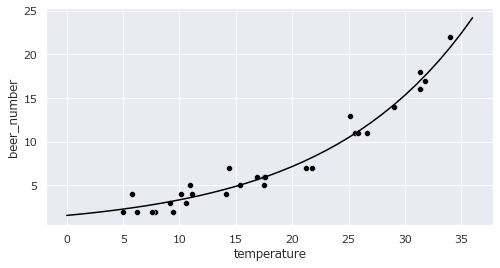

In [13]:
# 予測値の作成
x_plot = np.arange(0, 37)
pred = mod_pois.predict(pd.DataFrame({'temperature': x_plot}))

# 散布図
sns.scatterplot(x='temperature', y='beer_number',
                data=beer, color='black')
# 回帰曲線を上書き
sns.lineplot(x=x_plot, y=pred, color='black')

### 実装：回帰係数の解釈

In [14]:
# 気温が1℃のときの販売個数の期待値
exp_val_1 = pd.DataFrame({'temperature': [1]})
pred_1 = mod_pois.predict(exp_val_1)

# 気温が2℃のときの販売個数の期待値
exp_val_2 = pd.DataFrame({'temperature': [2]})
pred_2 = mod_pois.predict(exp_val_2)

# 気温が1℃上がると、販売個数は何倍になるか
round(pred_2 / pred_1, 3)

0    1.079
dtype: float64

In [15]:
# 係数のexpをとる
round(np.exp(mod_pois.params['temperature']), 3)

1.079